In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.transpiler.passes import RemoveBarriers

from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_simulated_annealing

import matplotlib.pyplot as plt
from pylatexenc import *
import numpy as np
import sympy
import itertools
from itertools import product

# Boolean Quantum ROM

In this notebook I will discuss the standard implementation of Boolean Quantum ROM, and then we will undergo some analysis to reduce the number of gates needed in the circuit.

Given a binary string of length $n$, denoted by $x = x_0\dots x_{n-1}$, let $f:\mathbb{F}_2^n\to\mathbb{F}_2$ be a Boolean function. The goal is to design a quantum circuit that implements $f$ via $\ket{x}_n\otimes\ket{0}\to\ket{x}_n\otimes\ket{f(x)}$.

## The Straightforward Approach
 The most straightforward implementation is as follows:

*  Compute the 'ON' set, i.e., $\{x\in\mathbb{F}_2^n : f(x) = 1\}$.
*  For each $z\in\text{ON}$, we do the following:

1)   We act an $X$ gate on the registers $i$ for which $z_i=0$. The result is that $x = \ket{1\dots 1}_n$ if and only if $x=z$.
2)   Act a multi-controlled $X$ gate a the target register initialized to $\ket{0}$, controlled by the $n$ registers storing the input value $\ket{x}_n$. The result is that the target register is $\ket{1}$ if and only if $x=z$.
3)   Uncompute the first step by again acting with $X$ gates on the registrs $i$ for which $z_i=0$.

At the end of this algorithm, the target register will be 1 if and only if the input $x \in\text{ON}$, and zero otherwise, which matches the behavior of the function $f(x)$. Let's implement this version below:

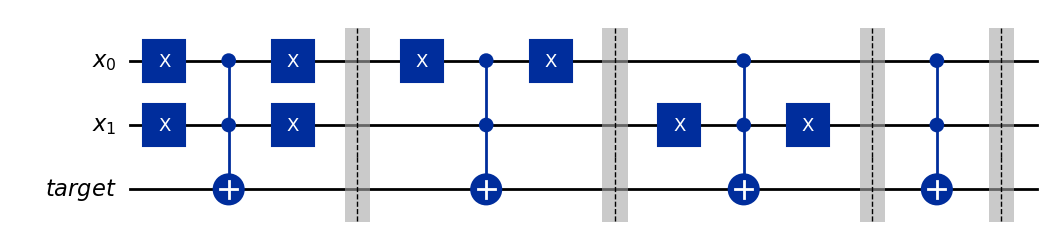

In [2]:
def U_f0(f,n):
    """
    Creates a circuit implementing the unitary map U_f0 taking |x> |0> --> |x>|f(x)>.
    
    f: a Boolean function taking a binary string of length n into the values {0,1}.
    n: Length of the binary input on which f acts.

    Returns a quantum circuit U_f0 implementing f as above
    """

    # Compute the ON set:
    
    # Generate all possible binary inputs to f
    all_binary_inputs =  list(map(list, list(itertools.product([0, 1], repeat=n))))
    # Select those elements for which f(x) == 1
    ON_set = [x for x in all_binary_inputs if f(x) == 1]

    
    # Create a quantum circuit to initialize the input values and store the output value
    quantum_registers = QuantumRegister(size = n,name = 'x')
    target_register = QuantumRegister(size = 1,name = 'target')
    qc = QuantumCircuit(quantum_registers,target_register, name = r'$U_f$')

    for z in ON_set: # For each element z in the ON set...
        # Act an X gate on the bits for which z[i] == 0
        for i in range(len(z)):
            if z[i] == 0:
                qc.x(quantum_registers[i])
                
        # Act a MCX gate (controlled by z) on the target
        qc.mcx(quantum_registers,target_register)

        # Uncompute
        for i in range(len(z)):
            if z[i] == 0:
                qc.x(quantum_registers[i])

        # An place a barrier for readability
        qc.barrier()

    # Return the circuit U_f.
    return qc

def f(x):
    return 1
        
output = U_f0(f,2)
output.draw(output='mpl')

# Identifying the Simplifications 

We can identify two clear redudancies that we will aim to fix in this notebook.

## Inefficiencies in Traversing the ON Set

First, in the process of iterating over all the $z \in \text{ON}$, it is inefficient to uncompute in each step. For example, suppose that the ON set consisted of $\{000,010\}$. Our algorithm would have us use 3 $X$ gates (one on each register), use a multicontrolled $X$ (MCX) gate controlled by this result, and then another 3 $X$ gates to uncompute. Then, we would use 2 $X$ gates on the first and third qubit, use our MCX gate, and then uncompute again.

Naive Circuit Implementation:


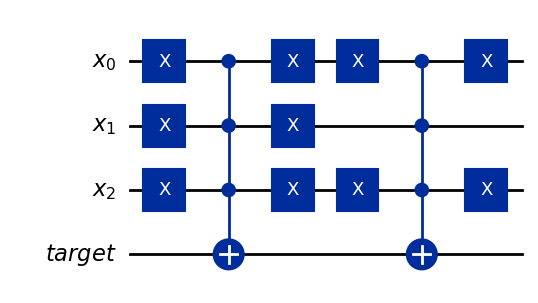

In [3]:
## Establish the qubits and circuits to compare the two implementations
quantum_registers = QuantumRegister(size = 3,name = 'x')
target_register = QuantumRegister(size = 1,name = 'target')
circuit_naive = QuantumCircuit(quantum_registers,target_register) # Quantum circuit to implement the naive method

# Define the function for which the ON set is {000,010}
def f(x):
    if x == [0,0,0] or x == [0,1,0]:
        return 1
    else:
        return 0

# Draw the naive circuit
circuit_naive.compose(RemoveBarriers()(U_f0(f,3)),inplace=True)
print('Naive Circuit Implementation:')
circuit_naive.draw(output='mpl')

Much more efficient would be to _not_ uncompute after the first step, and just act a single $X$ gate on the second register:

Slightly Simplified Circuit Implementation:


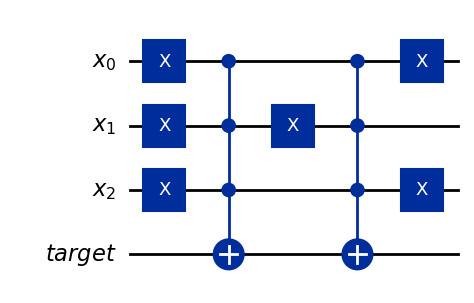

In [4]:
n = 3

## Establish the qubits and circuits to compare the two implementations
quantum_registers = QuantumRegister(size = 3,name = 'x')
target_register = QuantumRegister(size = 1,name = 'target')
circuit_simple = QuantumCircuit(quantum_registers,target_register) # Quantum circuit to implement the more efficient method

# f(0,0,0) == 1:
circuit_simple.x(quantum_registers[:])
circuit_simple.mcx(quantum_registers,target_register)

# f(0,1,0) == 1:
circuit_simple.x(quantum_registers[1])
circuit_simple.mcx(quantum_registers,target_register)

# Uncompute
circuit_simple.x(quantum_registers[[0,2]])

# Print Circuit
print('Slightly Simplified Circuit Implementation:')
circuit_simple.draw(output = 'mpl')

We can see the redudancy here in the fact that $X^2 = 1$, so the $X$ gates back-to-back have no effect. To clearly see these are the same, we can subtract their operator representations which vanishes:

In [5]:
print(np.array(Operator(circuit_naive),dtype = float)-np.array(Operator(circuit_simple),dtype = float))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/Users/robertweinbaum/anaconda3/lib/python3.11/site-packages/qiskit/quantum_info/operators/operator.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.data, dtype=dtype, copy=copy)


We refer to this first inefficiency as the ___inefficiency in traversing the ON set___ -- we would like to implement an algorithm that allows us to identify how to most efficiently traverse over the elements of the ON set with the fewest number of gates/shallowest gate depth.


## Simplifying the ON Set
The second inefficiency in our implementation can be seen as follows. Suppose the ON set consists of the inputs $\{111,110\}$. Then, rather than checking if the input $x = x_0x_1x_2$ is equal to either of these, we can simplify the problem by checking if $x_0x_1 = 11$, since the last digit essentially doesn't matter for the output. Again we see that this method is more efficient:

Naive Circuit Implementation:


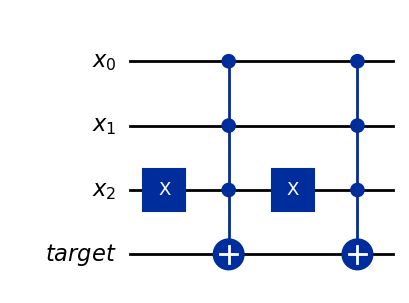

In [6]:
## Establish the qubits and circuits to compare the two implementations
quantum_registers = QuantumRegister(size = 3,name = 'x')
target_register = QuantumRegister(size = 1,name = 'target')
circuit_naive = QuantumCircuit(quantum_registers,target_register) # Quantum circuit to implement the naive method

# Define the function for which the ON set is {000,010}
def f(x):
    if x == [1,1,1] or x == [1,1,0]:
        return 1
    else:
        return 0

# Draw the naive circuit
circuit_naive.compose(RemoveBarriers()(U_f0(f,3)),inplace=True)
print('Naive Circuit Implementation:')
circuit_naive.draw(output='mpl')

Slightly Simplified Circuit Implementation:


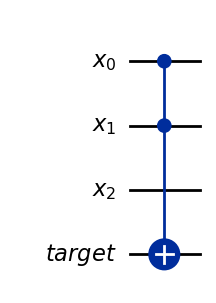

In [7]:
n = 3

## Establish the qubits and circuits to compare the two implementations
quantum_registers = QuantumRegister(size = 3,name = 'x')
target_register = QuantumRegister(size = 1,name = 'target')
circuit_simple = QuantumCircuit(quantum_registers,target_register) # Quantum circuit to implement the more efficient method

# f(1,1,*) == 1:
circuit_simple.mcx(quantum_registers[[0,1]],target_register)


# Print Circuit
print('Slightly Simplified Circuit Implementation:')
circuit_simple.draw(output = 'mpl')

In [8]:
print('And their operator representations are equal as well:\n')
print(np.round(np.array(Operator(circuit_naive),dtype = float)-np.array(Operator(circuit_simple),dtype = float),3))

And their operator representations are equal as well:

[[-0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.]
 [ 0.  

We refer to this second inefficiency as the problem of ___simplfying the ON set___; i.e., reducing the number of entries that really must be checked to compute the output.

# Solving these problems

## Traversing the ON Set

The problem of traversing the ON set is less significant than the second problem we will solve, since we can get from any definite state $\ket{x}_n$ to any other definite state $\ket{y}_n$ with a circuit of depth 1 (by just acting $X$ gates on any channels which represent bits at which $x$ and $y$ differ, which can act in parallel); nonetheless, we would ideally like to reduce the total number of operations/gates required since this minimized opportunities for errors to accumulate in our computation. We can define the distance between any two definite states $\ket{x}_n$ and $\ket{y}_n$ to be the number of $X$ gates required to get from $\ket{x}_n$ to $\ket{y}_n$. This is equivalent to the number of bits in which $x$ and $y$ differ, which is known as the Hamming distance. 

Note: For later convenience, we allow the binary representation of $x$ and $y$ to consist of 0's, 1's, and dashes ('-') representing blank spaces in the binary expansion. Sometimes we will want to consider these blank entries when computing the Hamming distance, and other times not, so we included parameters in our function that determine if we want to ignore dashes or not.

In [11]:
def HammingDistance(x,y,ignore_dashes_in_second = True, ignore_dashes_in_either = True):
    """ 
    Computes the Hamming distance between two binary strings of equal length - x and y - where.

    x,y : lists of 0's, 1's, and '-' s of the same length (where '-' represent unknown bit values)
    
    ignore_dashes_in_second: Boolean that determined whether blank spaces in y are counted in the Hamming distance 
                            (if True then these are not counted)
    ignore_dashes_in_second: Boolean that determined whether blank spaces in x OR y are counted in the Hamming distance 
                            (if True then these are not counted)

    Returns the Hamming distance between x and y
    """
    
    # Check that x and y are bit strings of equal length
    if len(x) != len(y):
        raise ValueError('Hamming distance between bit strings of different length is not defined')

    # Store the length of the bit strings
    n = len(x)
    
    # Count the number of bits in which x and y differ, and store the largest index where they differ
    distance = 0

    # Count the number of bits in which x and y differ, ignoring any bits that are blank (i.e. '-') for x or y
    if ignore_dashes_in_either == True:
        for i in range(n):
            if x[i] != '-' and y[i] != '-' and x[i] != y[i]:
                distance += 1
                location = i

    # Count the number of bits in which x and y differ, ignoring any bits that are blank (i.e. '-') for y
    elif ignore_dashes_in_second == True:
        for i in range(n):
            if y[i] != '-' and x[i] != y[i]:
                distance += 1
                location = i
    # Count the number of bits in which x and y differ
    else:
         for i in range(n):
            if x[i] != y[i]:
                distance += 1
                location = i
            
    # Return this count. 
    #For use in a later section, it is useful to record where two strings differ if they differ in one bit.
    if distance != 1:
        return distance, None
    else:
        return distance, location

## Test Cases: ##
print(HammingDistance([1,'-'],['-',1],False,False))
print(HammingDistance([0, '-', 0, 0], [1, 0, 0, '-'],True,True))

(2, None)
(1, 0)


The Hamming distance between two binary strings represents the number of $X$ gates required to get from one to the next. The task is to find a path through our ON set that minimizes the total distances, which is the famous traveling salesman problem. We write a function that computes all the distances and orders the ON set to find the path with the minimum total distance. Since simplifying our circuit does not require finding the optimal solution, we can leave a parameter (exact == True or False) in our function that determines whether the program will work to find the global minimum over all paths with a dynamic programming approach, or use simulated annealing to find a good, approximate minimum in a reasonable amount of computational time, which is good since the traveling salesman problem is NP hard and can take a long time to solve for larger ON sets.

In [14]:
def efficient_path(ON, exact = True):
    """
    Determines a permutation of the ON set that minimizes total distance (# of X gates)by solving (exactly or approximately) 
    the traveling salesman problem for traversing the ON set.
    
    ON: The ON set (a list whose elements are lists containing the elements 0 and 1, representing binary strings)
    exact: A Boolean that will determine whether the traveling salesman problem is solved using dynamic programming
            (yielding a global minimum but can take longer for larger ON sets), or simulated annleaing (yielding an approximate
            minimum but runs faster for larger ON sets).

    Returns:
    permutation: The optimal arangement of the ON set via as a list of indices corresponding to the order in which the elements of the
    ON set should be ordered.
    distance: The number of X gates required to traverse this ordering of the ON set
    localON: A list that is new copy of the ON set that also includes the all 1 string since the circuit needs to be re-initialized to
            the initial value at the end.
    
    
    """
    # Compute the bit length of each element of the ON set
    bit_length = len(ON[0])

    # Store a local copy of the ON set
    localON = 1*ON

    # Add the element `1...1' to the local copy of the ON set.
    
    # In our quantum circuit, this ensures that our starting & ending configurations are the same,
    # and so it needs to be included.
    if [1]*bit_length not in ON:
        localON.append([1]*bit_length)

    # Number of elements in the ON set
    n = len(localON)

    # Create an array to store distances between pairwise elements of the ON set
    distance_matrix = np.zeros([n,n])

    for i in range(n):
        for j in range(n):
            distance_matrix[i,j] = HammingDistance(localON[i],localON[j])[0]

    # In the exact case, use a Python package to implement a DP solution to the traveling salesman problem
    
    if exact == True:
        permutation, distance = solve_tsp_dynamic_programming(distance_matrix)

    # In the approximate case, use a Python package to implement a simulated annealing solution to the traveling salesman problem
    else:
        permutation, distance = solve_tsp_simulated_annealing(distance_matrix)


    ## Ensure that 1...1 is at the end of the path:
    permutation = np.array(permutation)
    permutation = list(np.roll(permutation, -[i for i in range(len(permutation)) if permutation[i] == max(permutation)][0]-1))

    
    # Return the permutation of elements of the ON set that minimzes distance, as well as the minimum distance and our new copy
    # of the ON set
    return permutation, distance, localON

## Test the code:

ON = [[1, 1, 0, 0], [1, 0, 0, 0], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 1, 1]]
perm, dist, ON = efficient_path(ON,True)

for i in range(len(ON)):
    print(ON[perm[i]])

[1, 1, 0, 0]
[1, 0, 0, 0]
[1, 0, 1, 0]
[1, 0, 1, 1]
[1, 1, 1, 1]


Finally, we implement this path through the elements of the ON set in a quantum circuit

Circuit Depth: 17


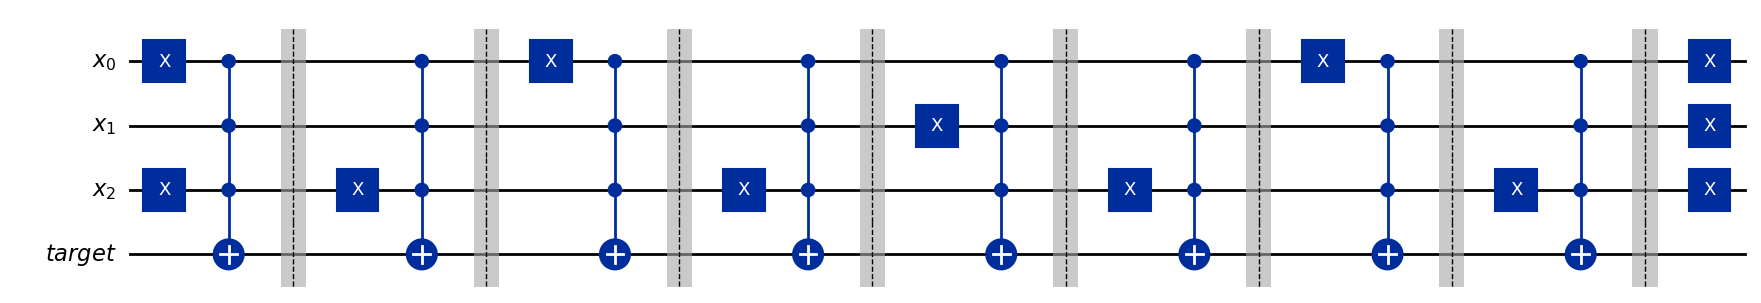

In [17]:
def U_f1(f,n,exact = True):
    """
    Creates a circuit implementing the unitary map U_f1 taking |x> |0> --> |x>|f(x)>, which traverses the ON
    set more efficiently than U_f0.
    
    f: a Boolean function taking a binary string of length n into the values {0,1}.
    n: Length of the binary input on which f acts.
    exact: a Boolean determining whether the output of the shortest path through ON 
            is only approximately the shortest (when False) or is actually the shortest (when True).

            The approximate version runs much more quickly for larger values of n.

    Returns a quantum circuit U_f1 implementing f as above.
    """


    # Create a quantum circuit to initialize the input values and store the output value
    quantum_registers = QuantumRegister(size = n,name = 'x')
    target_register = QuantumRegister(size = 1,name = 'target')
    qc = QuantumCircuit(quantum_registers,target_register, name = r'$U_f$')
    
    # Compute the ON set:
    
    # Generate all possible binary inputs to f
    all_binary_inputs =  list(map(list, list(itertools.product([1,0], repeat=n))))
    # Select those elements for which f(x) == 1
    ON_set = [x for x in all_binary_inputs if f(x) == 1]

    if ON_set == []:
        return qc

    # Generate the most efficient path through all the elements of the ON set, starting
    # and ending at |0>

    permutation, dist, ON_set = efficient_path(ON_set,exact = exact)

    # For the first element z in our re-ordered ON set, act an X gate on each register where z[i] = 0
    z = ON_set[permutation[0]]
    for j in range(len(z)):
            if z[j] == 0:
                qc.x(quantum_registers[j])

    # Then using an MCX gate record the result to the target register
    qc.mcx(quantum_registers,target_register)
    
    qc.barrier()

    # For each subsequenct z in our re-ordered ON set, we flip only the bits that differ between them using an X gate
    for i in range(1,len(ON_set)):
        z_old = z
        z = ON_set[permutation[i]]
        for j in range(len(z)):
            if z[j] != z_old[j]:
                qc.x(quantum_registers[j])

        # And as before use an MCX gate record a '1' to the target register if the input is in the ON set
        qc.mcx(quantum_registers,target_register)

        qc.barrier()

    # Finally, we return our quantum registers to their initial value
    for i in range(len(z)):
        if z[i] == 0:
            qc.x(quantum_registers[i])

    # Return the circuit U_f1
    return qc


## Test Case ##
def f(x):
    return 1
    
output = U_f1(f,3)
print('Circuit Depth:',output.depth())
output.draw(output='mpl')

We compare this to the depth of the initial naive circuit, and find improvement!

Circuit Depth: 22


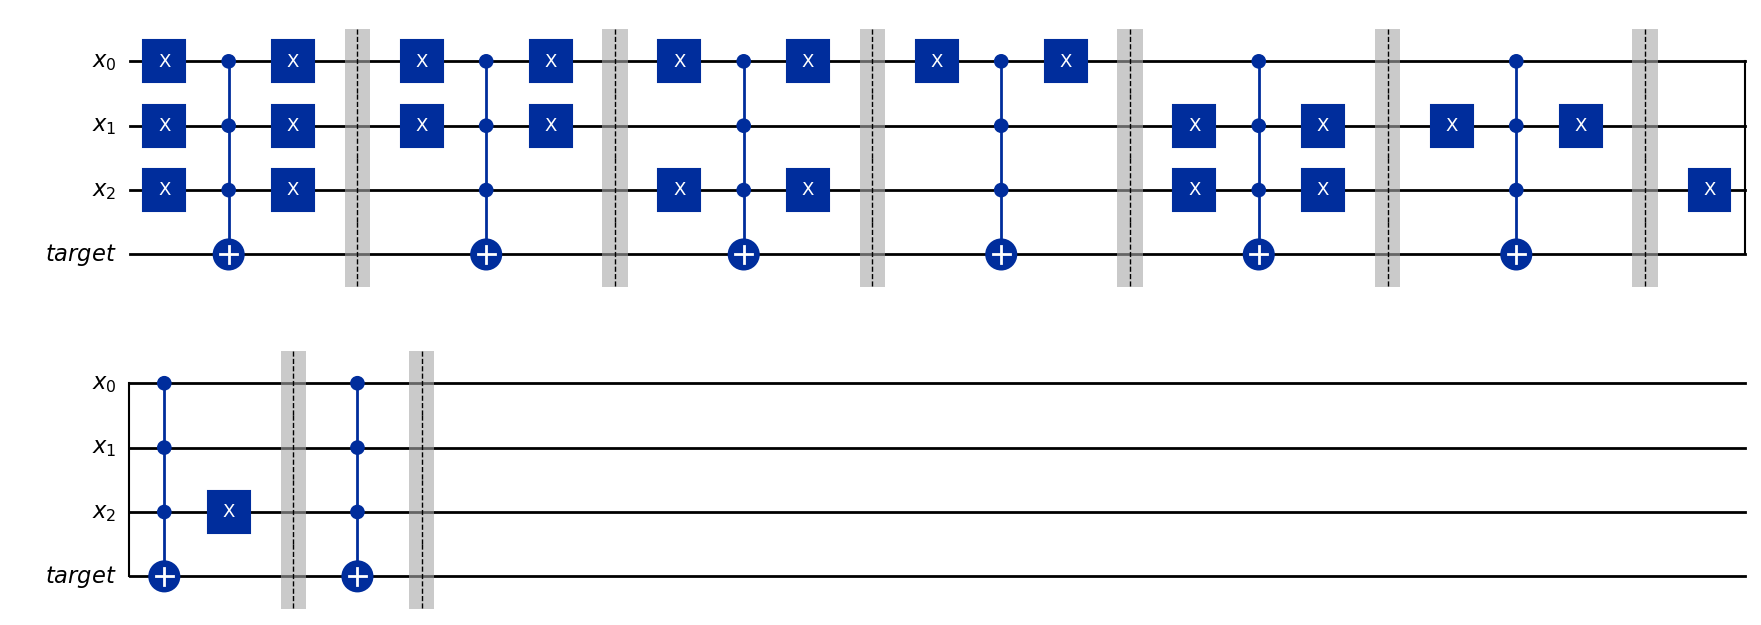

In [19]:
out = U_f0(f,3)
print('Circuit Depth:',out.depth())
out.draw(output='mpl')

## Simplifying the ON Set

Next, we will address the problem of how to simplify the ON set. Our approach will be to implement what is known as the Quine-McCluskey alogrithm, which works as follows.

First, we identify if two elements in the ON set differ in only one bit -- then, we can just evaluate the MCX gate controlled by the relevant bits. More explicitly, if 0001 and 1001 were both in the ON set, we can just check if the binary string is of the form -001 by using the appropriate $X$ gates and an MCX gate controlled by the last 3 bits. We must start by generating a list of enties in the ON set that differ by one bit. Rather than comparing all pairs of element in the ON set, we can group terms in the ON set by the number of 1's they have in their binary expansion; any two elements that differ by one bit will be off by one in the number of 1's in their binary expansion. We write a function that performs this grouping on the ON set.

In [21]:
def group_ON_set(ON):
    """
    Sorts the ON set into a list of list, grouped by entries having the same number of 1's in their binary expansion.

    ON: The ON set (a list whose elements are lists containing the elements 0 and 1, representing binary strings).

    Returns a list of groups, and the length of the binary strings in the ON set.
    """

    # Compute the length of the binary strings in the ON set
    bit_length = len(ON[0])

    # Form a list to store the groups
    groups = []

    # Add a list of elements of the ON set with the same number of 1's to the group list
    for i in range(bit_length+1):
        groups.append([x for x in ON if x.count(1) == i])

    # Return the list of groups, and the length fo the binary strings in the ON set (for later convenience)
    return groups, bit_length

Next, we need to start simplifying the ON set. We do this by finding and two elements in our ON set that differ by one bit (using pairwise comparisons of all elements with $k$-many 1's with elements with $k+1$-many 1's), and then store the result as a blank space in the entry that differs between the two elements, represented by a '-'. Thus, this would take the ON set $\{00,01\}$ to the set $\{0-\}.$ It's possible that more than one bit is irrelevant, for example if the ON set consists of $\{100,101,110,111\}$ then we should expect the reduced ON set to be $\{1--\}$ since the values of the second and third bits don't matter for the output. Thus, we recursively apply our comparison algorithm until the ON set is fully reduced, where the Hamming distnace between two bit strings $x$ and $y$ ignores spaces where $x$ or $y$ have a blank space (since theoretically that blank value can be set to agree between the two bit strings). In the literature of the Quine-McCluskey algorithm, this simplified ON set is referred to as the set of ___implicants___.

In [22]:
def simplify_ON_set(ON):
    """
    Simplifies the ON set as above

    ON: The ON set (a list whose elements are lists containing the elements 0 and 1, representing binary strings)

    Returns a list representing the simplified ON set (a list whose elements are lists containing the elements 0, 1, and '-',
            representing binary strings and blank spaces that can be either 0 or 1 encoded by '-')
    """
    # Form groupings of elements in our ON set based on how many 1's are present
    groups,bit_length = group_ON_set(ON)
    
    # Create a list to store the simplified ON set
    ON_reduced = []
    
    # Keep track of how many elements were merged (tells us when we are done)
    num_merges = 0

    # For each collection of elements in the ON set with k-many 1's...
    for i in range(len(groups)-1):
        # ensure both that set and the set with (k+1)-many 1's are nonempty...
        if groups[i] != [] and groups[i+1] != []:
            # then for every pair of elements in these two sets...
            for pair in itertools.product(groups[i],groups[i+1]):
                # compute their Hamming Distance and, if they differ in 1 bit, the location they differ.
                dist,loc = HammingDistance(pair[0],pair[1],False,False)
                # If they differ in one bit, create a new element with a '-' in the space where they differ
                if dist <= 1:   
                    num_merges += 1
                    new_elt = []
                    for i in range(bit_length):
                        if i == loc:
                            new_elt.append('-')
                        else:
                            new_elt.append(pair[0][i])
                    # and add this new element to our reduced ON set if its not already there
                    if new_elt not in ON_reduced:
                        ON_reduced.append(new_elt)

    # Any elements that didn't get merged and aren't already accounted for in our reduced ON set get added to the reduced ON set
    for x in ON:
        is_accounted_for = False
        i = 0
        while is_accounted_for == False and i < len(ON_reduced):
            if HammingDistance(x,ON_reduced[i],True,False)[0] == 0:
                is_accounted_for = True
            i+=1
        if is_accounted_for == False:
            ON_reduced.append(x)

    # If we didn't do any merges, we are done and return our input
    if num_merges == 0:
        return ON
        
    # If we did merge some elements, run this again to see if more can be merged
    else:
        return simplify_ON_set(ON_reduced)


## Test Case:

#Define our function f
def f(x):
    if x in [[0,1,0,0],[1,0,0,0],[1,0,0,1],[1,0,1,0],[1,1,0,0],[1,0,1,1],[1,1,1,0],[1,1,1,1]]:
        return 1

# Store the length of the binary input to f
n = 4

# Generate all possible binary inputs to f
all_binary_inputs =  list(map(list, list(itertools.product([0, 1], repeat=n))))

# Select those elements for which f(x) == 1
ON_set = [x for x in all_binary_inputs if f(x) == 1]
print('ON Set:',ON_set)
# Return the reduced ON set
print('Simplified ON Set:',simplify_ON_set(ON_set))

ON Set: [[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]]
Simplified ON Set: [[1, 0, '-', '-'], [1, '-', '-', 0], [1, '-', 1, '-'], ['-', 1, 0, 0]]


There is a possibility for redudancy in the simplified ON set, however. Consider the ON set $\{10,01,11\}$ which simplifies to $\{-1,1-\}$ Notice that the input '11' would cause both cases in our circuit to trigger, and so if we are checking whether the input is in the set ON for each case, and store the result to some target bit by flipping it from 0 to 1, there would be a double flip resulting in an erroneous output of 0. To solve this, we ensure that all elements of the simplifiedON set differ in at least 1 fixed bit, which in turn ensures that the parts of the ON set they cover are disjoint. In the case just discussed, we'd rather check if our input is in $\{10,-1\}$, since this covers the same ON set but each possibility is disjoint. We call the result the ___disjoint ON set___.

In [23]:
def find_disjoint_ON_set(ON,ON_simplified):
    """
    Creates a version of the simplified ON set where each element is disjoint.

    ON: The ON set (a list whose elements are lists containing the elements 0 and 1, representing binary strings)
    ON_simplified: The simplified ON set (a list whose elements are lists containing the elements 0, 1, and '-'
                    representing binary strings and unknown entries that can be 0 or 1)

    Returns the disjoint ON set as a list of lists whose elements are lists containing the elements 0, 1, and '-'
                    representing binary strings and unknown entries that can be 0 or 1.
    
    """
    # Create a copy of our simplified ON set
    essential_elements = ON_simplified*1

    # For every pair of elements in the simplified ON set
    for i in range(len(essential_elements)):
        for j in range(i):
            # If they can account for the same element in the ON set
            dist = HammingDistance(essential_elements[i],essential_elements[j],True,True)[0]
            if dist == 0:
                
                k = 0
                changed_entry = False
                
                # We change the element with fewer blanks ('edit'), and leave the other element ('keep') alone
                
                if essential_elements[i].count('-') <= essential_elements[j].count('-'):
                    edit = essential_elements[i]
                    keep = essential_elements[j]
                    
                else:
                    edit = essential_elements[j]
                    keep = essential_elements[i]

                # By setting the first spot where 'edit' is blank and 'keep' is fixed to the complementary value of 'keep',
                # this ensures the two elements of the reduced ON set are now disjoint
                    
                while k < len(edit) and changed_entry == False:
                    if edit[k] == '-' and keep[k] != '-':
                        edit[k] = (keep[k]+1) % 2
                        changed_entry = True
                    k += 1

                # If no such spot exists, we swap the role of 'edit' and 'keep'
                
                k = 0
                while k < len(edit) and changed_entry == False:
                    if keep[k] == '-' and edit[k] != '-':
                        keep[k] = (edit[k]+1) % 2
                        changed_entry = True
                    k+=1

    # Finally, we ensure that all elements of our ON set are accounted for in our new reduced ON set:
    missing_elements = []
    
    for x in ON:
        is_accounted_for = False
        i = 0
        while i < len(essential_elements) and is_accounted_for == False:
            if HammingDistance(x,essential_elements[i],True,False)[0] == 0:
                is_accounted_for = True
            i+=1

        if is_accounted_for == False:
            missing_elements.append(x)

    if len(missing_elements) > 0:
        raise ValueError(f'There was an issue finding the disjoint ON set. {missing_elements} is unaccounted for.')

    # And return the disjoint simplified ON set

    return essential_elements

## Test Case
    
ON = [[0,0,0,0],[0,1,0,0],[1,0,0,0],[1,0,1,0],[1,1,0,0],[1,0,1,1],[1,1,1,1]]
ON = [[0,1,0,0],[1,0,0,0],[1,0,0,1],[1,0,1,0],[1,1,0,0],[1,0,1,1],[1,1,1,0],[1,1,1,1]]
ON_simplified = simplify_ON_set(ON)
print('ON set:',ON)
print()
print('ON simplified:', ON_simplified)
print()
print('ON simplified and disjoint:',find_disjoint_ON_set(ON,ON_simplified))

ON set: [[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 1, 0, 0], [1, 0, 1, 1], [1, 1, 1, 0], [1, 1, 1, 1]]

ON simplified: [[1, 0, '-', '-'], [1, '-', '-', 0], [1, '-', 1, '-'], ['-', 1, 0, 0]]

ON simplified and disjoint: [[1, 0, '-', '-'], [1, 1, '-', 0], [1, 1, 1, 1], [0, 1, 0, 0]]


# Putting Things Together: A More Efficient Boolean Quantum ROM

Due to the simplification from simplifying the ON set, each $x_i$ in $x= x_0\dots x_{n-1}$ will be in the set $\{0,1,-\}$ which a $-$ means that it is allowed to be the value 0 or 1 (i.e. if $x_i = -$, the result of $f(x)$ does not depend on whether $x_i = 0$ or $x_i = 1$) and we can choose whichever is most convenient. If each $-$ is fixed to a particular value in $\{0,1\}$, then the problem of finding the path that traverses through all $x\in \text{ON}$ is the same as we solved earlier. However, different assignments to each of the $-$'s can result is more or less optimal paths through $\text{ON}.$ Here, we take a brute force approach of assigning all possible values to $- \in\{0,1\}$, and computing the total distance (i.e. number of $X$ gates) required to traverse the optimal path. Then we can choose the minimal distance of all possible choices of $-$, and the result is the most efficient path through all of the values we need to include in our circuit. In principle one could also avoid this step and set all the $-$'s to 0 or 1, but this may be inefficient in terms of the number of $X$ gates that need to be applied (though the impact on the circuit depth is not significant).

In [26]:
def all_filled(ON_simp):
    """
    Takes in a simplified ON set and return all possible combinations with the dashes filled with 0's and 1's.
    
    ON_simp: The simplified ON set (a list whose elements are lists containing the elements 0, 1, and '-'
                    representing binary strings and unknown entries that can be 0 or 1)

    Returns a list of candidate ON lists, whose elements are lists consisting of 0's and 1's representing the binary expansions of elements
            of the ON set.
    """
    # Flatten and record positions of '-'s
    rows, cols = len(ON_simp), len(ON_simp[0])
    flat = [ON_simp[i][j] for i in range(rows) for j in range(cols)]
    dash_positions = [idx for idx, val in enumerate(flat) if val == '-']
    k = len(dash_positions)

    # Iterate over all 2^k assignments of 0/1
    for bits in product([0, 1], repeat=k):
        new_flat = flat[:]  # shallow copy
        for pos, bit in zip(dash_positions, bits):
            new_flat[pos] = bit
    # Rechop to rows×cols
        new_ON = [new_flat[i*cols:(i+1)*cols] for i in range(rows)]
        yield new_ON


def most_efficient_path(ON,exact = True):
    """
    Iterate over the list of all possible filled in values of the ON set and find the path that minimizes the total distance/number of 
    X gates required.

    ON: The simplified ON set (a list whose elements are lists containing the elements 0, 1, and '-'
                    representing binary strings and unknown entries that can be 0 or 1).
    exact: a Boolean determining whether the output of the shortest path through ON 
            is only approximately the shortest (when False) or is actually the shortest (when True).

            The approximate version runs much more quickly for larger values of |ON|.

    Returns a list representing a version of the ON set filled in with 0's and 1's in such a ways that the number of X gates 
    required to traverse it is minimal or nearly minimal.
                    
    """

    # Initialize the best distance so far to infinity
    best_dist = np.inf

    # For every possible filled in version of the ON set
    for filledON in all_filled(ON):

        # Compute the distance required to traverse its optimal (or nearly optimal) ordering
        perm, dist, temp_ON = efficient_path(filledON,exact = exact)

        # And if it beats the best so far, store it as our leading candidate
        if dist < best_dist:
            best_dist = dist
            best_ON = temp_ON
            best_perm = perm
            
    # Return the leading candidate at the end of the computation.
    return best_perm, best_dist, best_ON


## Test Case
ON = [[0,1,0,0],[1,0,0,0],[1,0,1,0],[1,1,0,0],[1,0,1,1],[1,1,1,1]]

ON_simp = simplify_ON_set(ON)
perm, dist, ON = most_efficient_path(ON_simp)

for i in range(len(ON)):
    if i < len(ON_simp):
        print(f'Step {i}:',ON_simp[perm[i]],'is represented by',ON[perm[i]])
    else:
        print('Ending on',ON[perm[i]])

print(f'\n This requires {int(dist)} X gates')

Step 0: ['-', 1, 0, 0] is represented by [1, 1, 0, 0]
Step 1: [1, 0, '-', 0] is represented by [1, 0, 0, 0]
Step 2: [1, '-', 0, 0] is represented by [1, 0, 0, 0]
Step 3: [1, 0, 1, '-'] is represented by [1, 0, 1, 0]
Step 4: [1, '-', 1, 1] is represented by [1, 0, 1, 1]
Ending on [1, 1, 1, 1]

 This requires 6 X gates


# The Result:

At last, we put everything together into our final implementation of $f$.

In [27]:
def U_f(f,n,exact = True):
    """
    Creates a circuit implementing the unitary map U_f taking |x> |0> --> |x>|f(x)> with our inefficiencies eliminated!
    
    f: a Boolean function taking a binary string of length n into the values {0,1}.
    n: Length of the binary input on which f acts.
    exact: a Boolean determining whether the output of the shortest path through ON 
            is only approximately the shortest (when False) or is actually the shortest (when True).

            The approximate version runs much more quickly for larger values of n.

    Returns a quantum circuit U_f implementing f as above
    """


    # Create a quantum circuit to initialize the input values and store the output value
    quantum_registers = QuantumRegister(size = n,name = 'x')
    target_register = QuantumRegister(size = 1,name = 'target')
    qc = QuantumCircuit(quantum_registers,target_register, name = r'$U_f$')
    
    
    ## Compute the ON set ##
    # Generate all possible binary inputs to f
    all_binary_inputs =  list(map(list, list(itertools.product([1,0], repeat=n))))
    # Select those elements for which f(x) == 1
    ON_set = [x for x in all_binary_inputs if f(x) == 1]

    # If the ON set is trivial, we always return 0 for the target register (with a trivial circuit)
    if ON_set == []:
        return qc

    # Simplify and find the disjoint ON set
    ON_simp = simplify_ON_set(ON_set)
    ON_ess = find_disjoint_ON_set(ON_set,ON_simp)
    
    # Generate the most efficient path through all the elements of the ON set, starting and ending at |0>
    permutation, dist, ON_set = most_efficient_path(ON_ess,exact = exact)
    
    # For the first element z in our re-ordered ON set, act an X gate on each register where z[i] = 0
    z = ON_set[permutation[0]]
    for i in range(len(z)):
        if z[i] == 0:
            qc.x(quantum_registers[i])
            
    # And check only the relevant bits (i.e. ones that are not '-')
    ctrl_index = [i for i in range(len(z)) if ON_ess[permutation[0]][i] != '-']

    # If all bits are irrelevant, just act an X gate on the targer
    if ctrl_index == []:
        qc.x(target_register)
    # Otherwise use the relevant bits as controls for an MCX gate acting on the target
    else:
        qc.mcx(quantum_registers[ctrl_index],target_register)

    qc.barrier()

    # For each subsequenct z in our re-ordered ON set, we flip only the bits that differ between them using an X gate
    for i in range(1,len(ON_set)):
            z_old = z
            z = ON_set[permutation[i]]
        
            for j in range(len(z)):
                if z[j] != z_old[j]:
                    qc.x(quantum_registers[j])
                    
            # Again we check which registers are storing relevant bits, and act with X gates or MCX gates accordingly:
            if i < len(ON_ess):
                
                ctrl_index = [k for k in range(len(z)) if ON_ess[permutation[i]][k] != '-']
                
                if ctrl_index == []:
                    qc.x(garbage[i])
                    
                else:
                    qc.mcx(quantum_registers[ctrl_index],target_register)
        
            qc.barrier()

    # Finally, we return our quantum registers to their initial value
    
    for i in range(len(z)):
        if z[i] == 0:
            qc.x(quantum_registers[i])
            
    # And return our quantum circuit
    return qc

Again, we take an example function and compute the simplified circuit and the original naive circuit. We see the circuit depth is greatly reduced and that their operator representations are identical.

Circuit Depth: 8


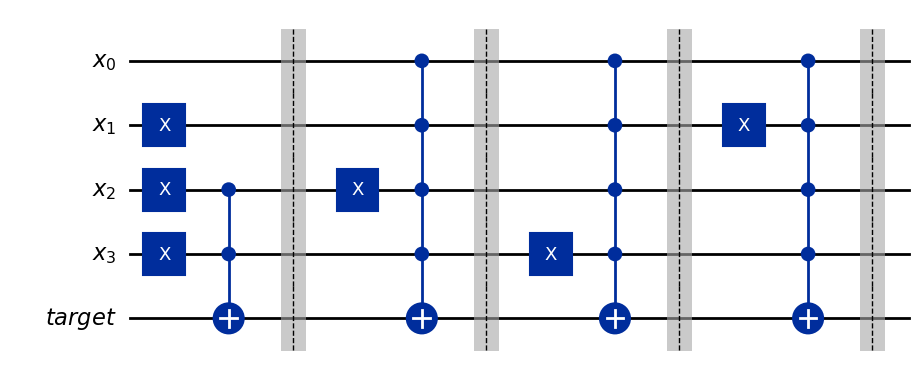

In [45]:
## Test Case:

def f(x):
    if x in [[0,1,0,0],[1,0,0,0],[1,0,1,0],[1,1,0,0],[1,0,1,1],[1,1,1,1],[0,0,0,0]]:
        return 1
    else:
        return 0
simple_output = U_f(f,4)
print('Circuit Depth:',simple_output.depth())
simple_output.draw(output='mpl')

Circuit Depth: 19


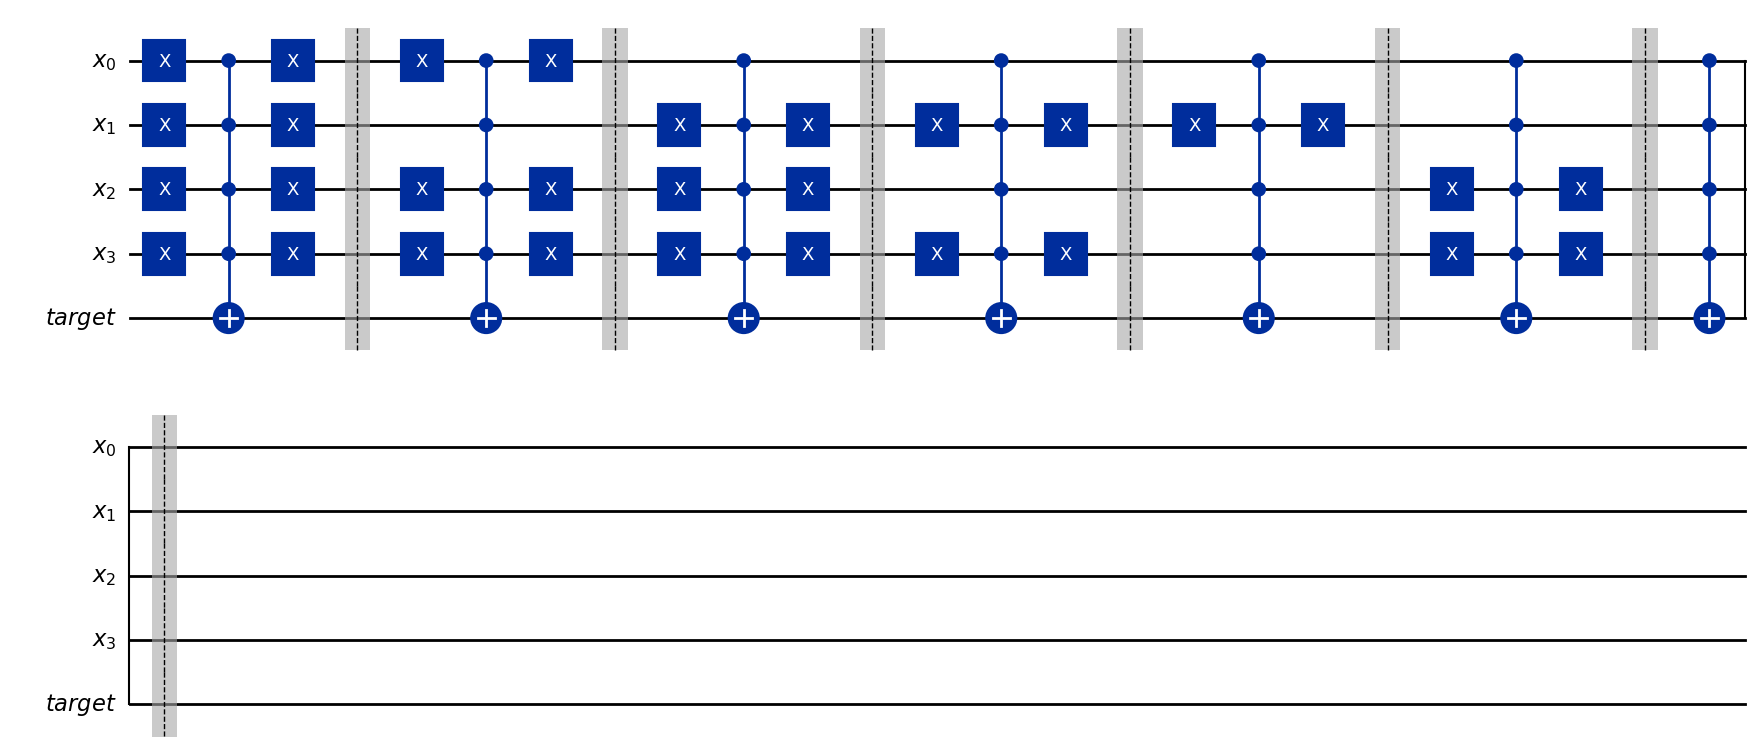

In [46]:
naive_output = U_f0(f,4)
print('Circuit Depth:',naive_output.depth())
naive_output.draw(output='mpl')

In [47]:
np.round(np.array(Operator(naive_output),dtype = float),2)-np.round(np.array(Operator(simple_output),dtype = float),2)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

The more extreme case is the function $f(x_0,x_1,x_2,x_3) = 1$ that always returns the output 1:

Simplified Circuit Depth: 1


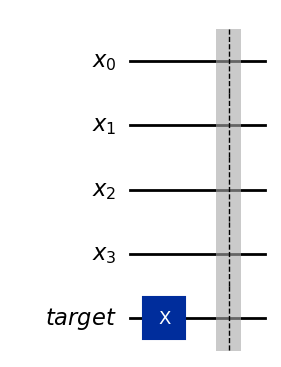

In [48]:
def f(x):
   return 1
simple_output = U_f(f,4)
print('Simplified Circuit Depth:',simple_output.depth())
simple_output.draw(output='mpl')

Circuit Depth: 46


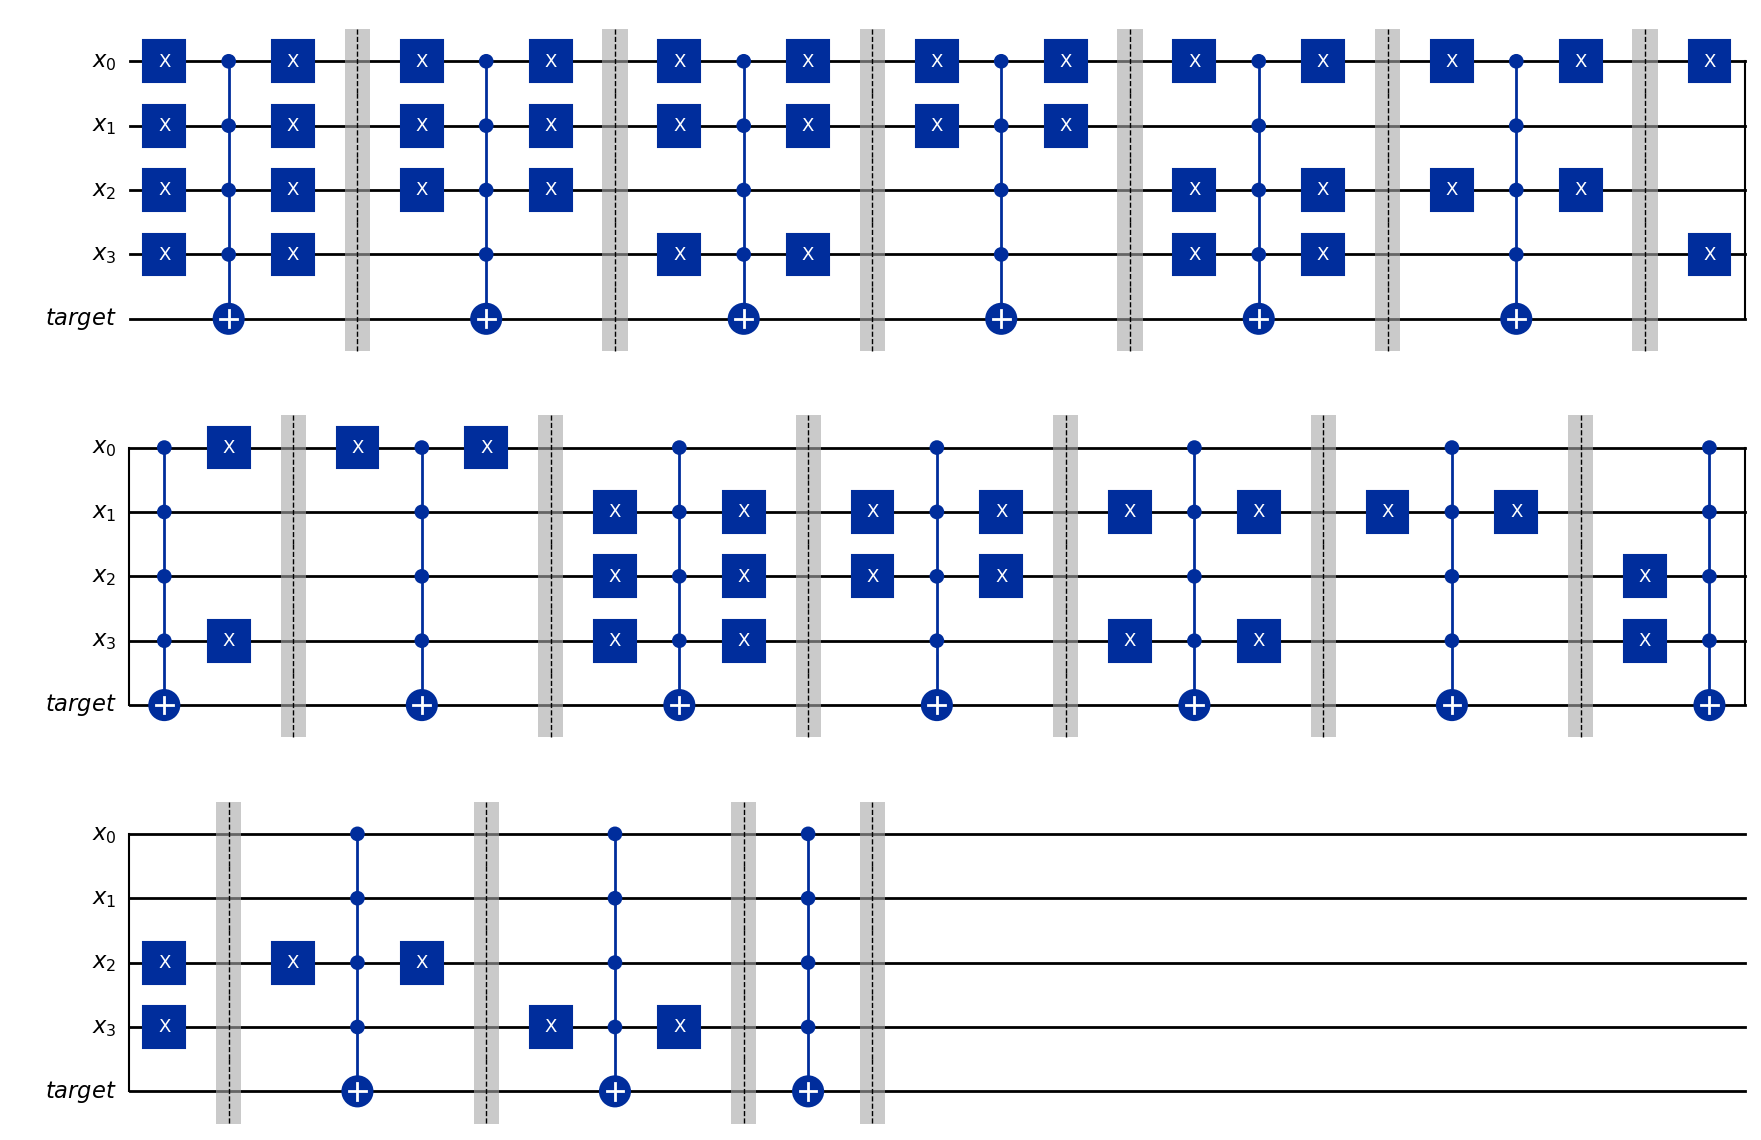

In [49]:
naive_output = U_f0(f,4)
print('Circuit Depth:',naive_output.depth())
naive_output.draw(output='mpl')

In [50]:
np.round(np.array(Operator(naive_output),dtype = float),2)-np.round(np.array(Operator(simple_output),dtype = float),2)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])